In [1]:
from astroquery.gaia import Gaia
from astropy.table import Table, vstack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import os

In [7]:
# Template for the query with placeholders for RA ranges
query_template = """
SELECT
    source_id,
    parallax,
    ra,
    ra_error,
    dec,
    dec_error,
    pmra,
    pmra_error,
    pmdec,
    pmdec_error,
    astrometric_excess_noise,
    phot_g_mean_mag AS mg,
    phot_g_mean_flux_error AS mg_error,
    phot_bp_mean_mag AS mbp,
    phot_bp_mean_flux_error AS mbp_error,
    phot_rp_mean_mag AS mrp,
    phot_rp_mean_flux_error AS mrp_error,
    bp_rp,
    bp_g,
    g_rp,
    mh_gspphot,
    distance_gspphot,
    phot_g_mean_flux,
    phot_g_mean_flux_error,
    phot_bp_mean_flux,
    phot_bp_mean_flux_error,
    phot_rp_mean_flux,
    phot_rp_mean_flux_error,
    teff_gspphot,
    azero_gspphot,
    ag_gspphot,
    ebpminrp_gspphot
FROM
    gaiadr3.gaia_source
WHERE
    parallax_over_error > 30
    AND phot_g_mean_flux_over_error > 50
    AND phot_rp_mean_flux_over_error > 20
    AND phot_bp_mean_flux_over_error > 20
    AND phot_bp_rp_excess_factor < 1.3 + 0.06 * POWER(bp_rp, 2)
    AND phot_bp_rp_excess_factor > 1.0 + 0.015 * POWER(bp_rp, 2)
    AND bp_rp IS NOT NULL
    AND phot_bp_mean_mag IS NOT NULL
    AND phot_rp_mean_mag IS NOT NULL
    AND dec > 0
    AND ra BETWEEN {ra_min} AND {ra_max}
    AND teff_gspphot BETWEEN 5500 AND 6060
    AND phot_variable_flag = 'NOT_AVAILABLE'
"""

# Function to execute a query for a given RA range with retries
def execute_query(ra_min, ra_max, max_retries=5):
    query = query_template.format(ra_min=ra_min, ra_max=ra_max)
    retries = 0
    while retries < max_retries:
        try:
            job = Gaia.launch_job_async(query)
            return job.get_results()
        except Exception as e:
            print(f"Error: {e}. Retrying ({retries + 1}/{max_retries})...")
            retries += 1
            time.sleep(10)  # Wait before retrying
    raise Exception("Max retries reached. Could not complete the query.")

# Define RA ranges to split the query
ra_ranges = [(0, 50), (50, 100), (100, 150), (150, 200), (200,250), (250, 300), (300, 350), (350, 360)]

# Directory to save intermediate results
output_dir = 'gaia_results'
os.makedirs(output_dir, exist_ok=True)

# Execute queries and save intermediate results
for i, (ra_min, ra_max) in enumerate(ra_ranges):
    try:
        result = execute_query(ra_min, ra_max)
        # Save the intermediate result to a CSV file
        output_path = os.path.join(output_dir, f'gaia_results_{ra_min}_{ra_max}.csv')
        result.write(output_path, format='csv', overwrite=True)
        print(f"Saved results for RA range {ra_min}-{ra_max} to {output_path}")
    except Exception as e:
        print(f"Failed to complete query for RA range {ra_min}-{ra_max}: {e}")

# Combine all intermediate CSV files into a single final CSV file
combined_results = []
for file_name in os.listdir(output_dir):
    if file_name.endswith('.csv'):
        file_path = os.path.join(output_dir, file_name)
        df = pd.read_csv(file_path)
        combined_results.append(df)

# Combine all dataframes into one
final_df = pd.concat(combined_results, ignore_index=True)

# Save the final combined CSV file
final_output_path = 'low_variability_stars_combined.csv'
final_df.to_csv(final_output_path, index=False)
print(f"Combined results saved to {final_output_path}")

INFO: Query finished. [astroquery.utils.tap.core]
Saved results for RA range 0-50 to gaia_results/gaia_results_0_50.csv
INFO: Query finished. [astroquery.utils.tap.core]
Saved results for RA range 50-100 to gaia_results/gaia_results_50_100.csv
INFO: Query finished. [astroquery.utils.tap.core]
Saved results for RA range 100-150 to gaia_results/gaia_results_100_150.csv
INFO: Query finished. [astroquery.utils.tap.core]
Saved results for RA range 150-200 to gaia_results/gaia_results_150_200.csv
INFO: Query finished. [astroquery.utils.tap.core]
Saved results for RA range 200-250 to gaia_results/gaia_results_200_250.csv
INFO: Query finished. [astroquery.utils.tap.core]
Saved results for RA range 250-300 to gaia_results/gaia_results_250_300.csv
INFO: Query finished. [astroquery.utils.tap.core]
Saved results for RA range 300-350 to gaia_results/gaia_results_300_350.csv
INFO: Query finished. [astroquery.utils.tap.core]
Saved results for RA range 350-360 to gaia_results/gaia_results_350_360.csv


In [8]:
# Path to your .csv file
file_path = 'low_variability_stars_combined.csv'

# Read the .csv file into a DataFrame
data = pd.read_csv(file_path)

# # Display the first few rows of the DataFrame
# print(df.head())

# # Correct for extinction
# mg_corrected = data['mg']# - data['ag_gspphot']
# mbp_corrected = data['mbp']# - data['ag_gspphot']
# mrp_corrected = data['mrp']# - data['ag_gspphot']

# # Compute an approximate combined absolute magnitude
# # combined_magnitude = (mg_corrected + mbp_corrected + mrp_corrected) / 3
# combined_magnitude = (mg_corrected)
# # combined_magnitude = (mbp_corrected + mrp_corrected)

# # Filter stars based on the combined absolute magnitude
# # bright_stars = data[combined_magnitude < 5]
# bright_stars = data # Already choosen

# Extract corrected magnitudes and colors for plotting
mg_corrected = data['mg'] - data['ag_gspphot']
bp_rp_corrected = data['bp_rp'] - data['ebpminrp_gspphot']
bp_rp_error = data['mbp_error'] + data['mrp_error']
gaia_ids = data['SOURCE_ID']
RA = data['ra']
DEC = data['dec']
PRA = data['pmra']
PDEC = data['pmdec']
extnc = data['ag_gspphot']
Teff = data['teff_gspphot']
Iron_den = data['mh_gspphot']

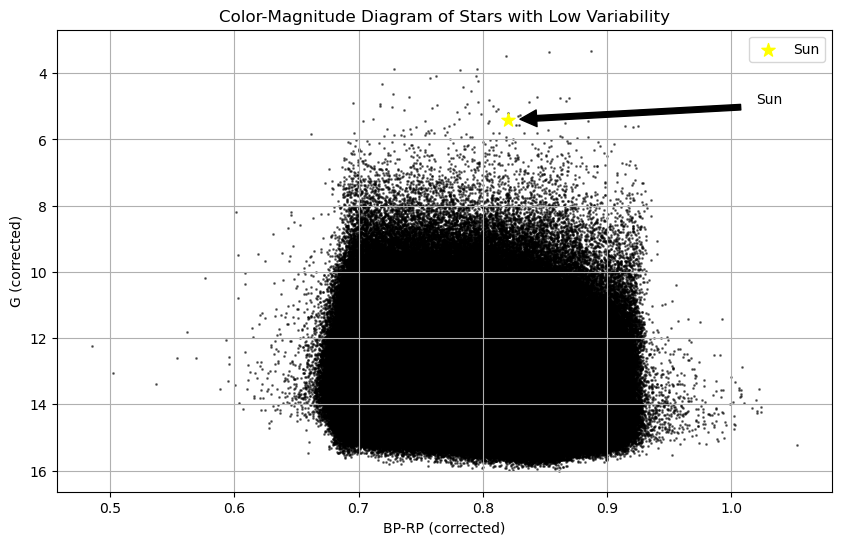

In [9]:
# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(bp_rp_corrected, mg_corrected, s=1, c='black', alpha=0.5)
plt.gca().invert_yaxis()
plt.xlabel('BP-RP (corrected)')
plt.ylabel('G (corrected)')
plt.title('Color-Magnitude Diagram of Stars with Low Variability')
plt.grid(True)

# Define properties of the Sun
sun_bp_rp = 0.82  # Example value for Sun's BP-RP color index
sun_mg = 5.409  

# Plot the Sun
plt.scatter(sun_bp_rp, sun_mg, s=100, c='yellow', marker='*', label='Sun')

# Annotate the Sun
plt.annotate('Sun', xy=(sun_bp_rp, sun_mg), xytext=(sun_bp_rp + 0.2, sun_mg - 0.5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.legend()  # Show legend

plt.show()

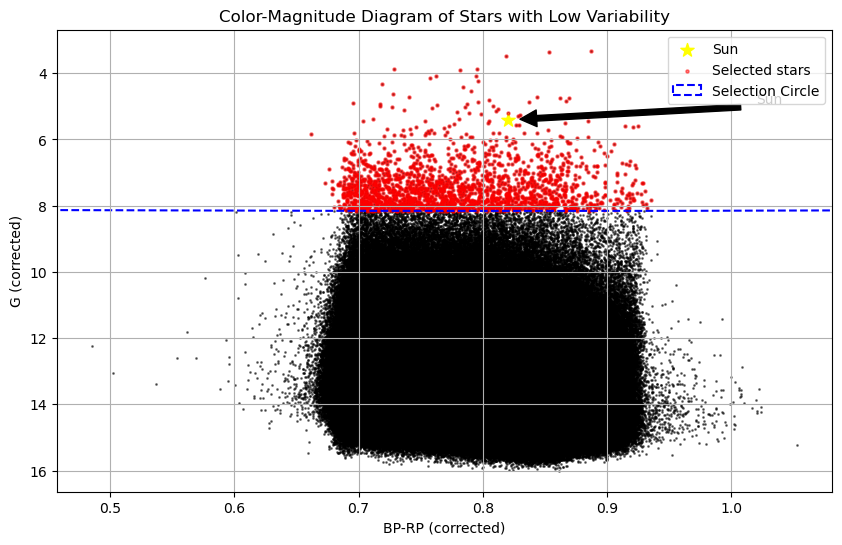

                   SOURCE_ID   parallax          ra  ra_error        dec  \
2320720  1328866562170960512  44.057470  243.668787  0.033465  33.858226   
1850673   974887555341533440  59.340805  108.959110  0.040675  47.239137   
1922689   714079652021800320   8.843072  138.808500  0.027871  34.633731   
1583266  2513664248895784192  44.596286   34.507642  0.275001   1.759456   
2213545  1722385725122129408  22.903042  222.591143  0.057046  82.510946   
...                      ...        ...         ...       ...        ...   
2186755  1251328585567327744  13.417842  206.697864  0.050176  22.524016   
460586   4547861262518847104  10.123589  257.015824  0.014282  17.242780   
1321870   152542296164043008  11.847121   65.933341  0.073192  28.185783   
1847305   975765721535076608  16.538229  114.863699  0.047784  47.970221   
1442041   544851377850397440  14.573746   54.225921  0.012952  74.628412   

         dec_error        pmra  pmra_error       pmdec  pmdec_error  ...  \
2320720   0

In [10]:
# Calculate the distance of each star from the Sun in the color-magnitude diagram
distances = np.sqrt((bp_rp_corrected - sun_bp_rp) ** 2 + (mg_corrected - sun_mg) ** 2)

# Sort the stars by their distance to the Sun
sorted_indices = np.argsort(distances)

# Select the 2000 closest stars
selected_indices = sorted_indices[:2000]
selected_stars = data.iloc[selected_indices]

# Determine the radius of the circle that includes these 2000 stars
radius = distances[selected_indices].max()

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(bp_rp_corrected, mg_corrected, s=1, c='black', alpha=0.5)
plt.gca().invert_yaxis()
plt.xlabel('BP-RP (corrected)')
plt.ylabel('G (corrected)')
plt.title('Color-Magnitude Diagram of Stars with Low Variability')
plt.grid(True)

# Plot the Sun
plt.scatter(sun_bp_rp, sun_mg, s=100, c='yellow', marker='*', label='Sun')
plt.annotate('Sun', xy=(sun_bp_rp, sun_mg), xytext=(sun_bp_rp + 0.2, sun_mg - 0.5),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Plot the selected stars
plt.scatter(bp_rp_corrected[selected_indices], mg_corrected[selected_indices], s=5, c='red', alpha=0.5, label='Selected stars')

# Plot the circle
circle = plt.Circle((sun_bp_rp, sun_mg), radius, color='blue', fill=False, linewidth=1.5, linestyle='--', label='Selection Circle')
plt.gca().add_artist(circle)

plt.legend()  # Show legend

plt.show()

# Print the details of the selected 2000 stars
print(selected_stars)

# Save the details of the selected 2000 stars to a CSV file
selected_stars.to_csv('selected_2000_stars.csv', index=False)
print(f"Details of the selected 2000 stars have been saved to 'selected_2000_stars.csv'")